In [102]:
import sys
sys.path.append('../Automatic-Circuit-Discovery/')
sys.path.append('..')
import os
import re
import json
import pandas as pd
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('seaborn-v0_8-paper')


device = t.device("cuda" if t.cuda.is_available() else "CPU")
print(device)

cuda


In [105]:
from acdc.docstring.utils import get_docstring_subgraph_true_edges
RUN_NAME = 'abs_edges'
with open(f'acdc_edges_num_passes.json', 'r') as f:
    num_passes = json.load(f)
with open(f'acdc_edges_acdc_scores.json', 'r') as f:
    acdc_scores = json.load(f)
    
with open(f'acdcpp_best_acdcpp_scores.json', 'r') as f:
    acdcpp_scores = json.load(f)

acdcpp_scores = acdcpp_scores[list(acdcpp_scores.keys())[0]]

true_edges_tuples = get_docstring_subgraph_true_edges()
true_edges = set()
replace_parens = lambda tup: str(tup).replace('(', '[').replace(')', ']').replace('[None,]', '[None]').replace('None', ':')

for child_name, child_idx, parent_name, parent_idx in true_edges_tuples:
    true_edges.add(f'{child_name}{replace_parens(child_idx)}{parent_name}{replace_parens(parent_idx)}')

for acdc_edge in set(acdc_scores[list(acdc_scores.keys())[0]].keys()) - set(acdcpp_scores.keys()):
    acdcpp_scores[acdc_edge] = acdc_scores[list(acdc_scores.keys())[0]][acdc_edge]
    
for acdcpp_edge in set(acdcpp_scores.keys()) - set(acdc_scores[list(acdc_scores.keys())[0]].keys()):
    acdc_scores[list(acdc_scores.keys())[0]][acdcpp_edge] = acdcpp_scores[acdcpp_edge]

# Attribution Scores Scatter Plot

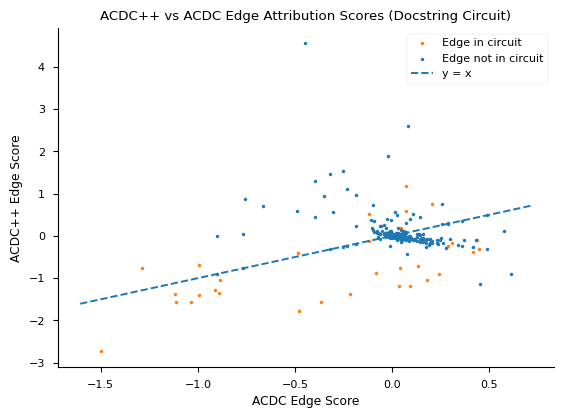

In [106]:
acdc_attrs = []
acdcpp_attrs = []
is_in_circuit = []

for acdc_attr_key in acdc_scores[list(acdc_scores.keys())[0]]:
    acdcpp_attr = acdcpp_scores.get(acdc_attr_key, None)
    if acdcpp_attr:
        acdc_attrs.append(acdc_scores[list(acdc_scores.keys())[0]][acdc_attr_key])
        acdcpp_attrs.append(acdcpp_attr)
        if acdc_attr_key in true_edges:
            is_in_circuit.append(True)
        else:
            is_in_circuit.append(False)

scatter_df = pd.DataFrame({'acdc_attrs': acdc_attrs, 'acdcpp_attrs': acdcpp_attrs, 'is_in_circuit': is_in_circuit})

ax = plt.gca()
ax.scatter(
    scatter_df[scatter_df['is_in_circuit'] == True]['acdc_attrs'],
    scatter_df[scatter_df['is_in_circuit'] == True]['acdcpp_attrs'],
    marker='o', s=5,c='#ff7f0e', label='Edge in circuit'
)
ax.scatter(
    scatter_df[scatter_df['is_in_circuit'] == False]['acdc_attrs'],
    scatter_df[scatter_df['is_in_circuit'] == False]['acdcpp_attrs'],
    marker='o', s=5,c='#1f77b4', label='Edge not in circuit'
)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, linestyle='dashed', label='y = x')
ax.set_xlabel('ACDC Edge Score')
ax.set_ylabel('ACDC++ Edge Score')
ax.set_title('ACDC++ vs ACDC Edge Attribution Scores (Docstring Circuit)')
ax.legend()
plt.savefig('ACDC++_vs_ACDC_Scores_Docstring.png')

In [27]:
mpl.rcParams["axes.prop_cycle"]

'#1f77b4'
'#ff7f0e'
'#2ca02c'
'#d62728'
'#9467bd'
'#8c564b'
'#e377c2'
'#7f7f7f'
'#bcbd22'
'#17becf'


# ROC Curve

In [28]:
print(np.quantile(acdc_attrs, [0, .1, .25, .5, 0.75, .9, 1]))
print(np.quantile(acdcpp_attrs, [0, .1, .25, .5, 0.75, .9, 1]))

[2.98023224e-07 2.87467241e-04 1.21507049e-03 4.65348363e-03
 1.72266215e-02 7.10947990e-02 1.42714685e+00]
[4.10713255e-07 2.24406437e-04 1.17274639e-03 4.93619125e-03
 1.97799378e-02 7.21177876e-02 4.55413342e+00]


In [51]:
def edges_after_acdcpp(thresh):
    edges = set()
    for edge, attr in acdcpp_scores.items():
        # If attr < thresh, would've been removed
        if attr >= thresh:
            edges.add(edge)
    return edges

data = {
    'Threshold': [0],
    'ACDCpp TPR': [1],
    'ACDCpp TNR': [0],
    'ACDCpp FPR': [1],
    'ACDCpp FNR': [0],
    'TPR': [1],
    'TNR': [0],
    'FPR': [1],
    'FNR': [0],
}

# This should be the same as acdcpp_attrs_set, assert just in case
all_edges = set(acdc_scores[list(acdc_scores.keys())[0]].keys())

for thresh in acdc_scores.keys():
    data['Threshold'].append(float(thresh))
    # Variables prefixed with pp_ are after ADCDCpp only
    pp_edges = edges_after_acdcpp(float(thresh))
    edges = set(acdc_scores[thresh].keys())
    
    pp_tp = len(pp_edges.intersection(true_edges))
    pp_tn = len((all_edges - true_edges).intersection(all_edges - pp_edges))
    pp_fp = len(pp_edges - true_edges)
    pp_fn = len(true_edges - pp_edges)

    tp = len(edges.intersection(true_edges))
    tn = len((all_edges - true_edges).intersection(all_edges - edges))
    fp = len(edges - true_edges)
    fn = len(true_edges - edges)

    pp_tpr = pp_tp / (pp_tp + pp_fn)
    pp_tnr = pp_tn / (pp_tn + pp_fp)
    pp_fpr = 1 - pp_tnr
    pp_fnr = 1 - pp_tpr

    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = 1 - tnr
    fnr = 1 - tpr

    data['ACDCpp TPR'].append(pp_tpr)
    data['ACDCpp TNR'].append(pp_tnr)
    data['ACDCpp FPR'].append(pp_fpr)
    data['ACDCpp FNR'].append(pp_fnr)

    data['TPR'].append(tpr)
    data['TNR'].append(tnr)
    data['FPR'].append(fpr)
    data['FNR'].append(fnr)

df = pd.DataFrame(data)
# Add thresh inf to end of df
row = [np.inf, 0, 1, 0, 1, 0, 1, 0, 1]
df.loc[len(df)] = row

In [56]:
df.head(20)

,Threshold,ACDCpp TPR,ACDCpp TNR,ACDCpp FPR,ACDCpp FNR,TPR,TNR,FPR,FNR
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,0.001600,1.000000,0.291791,0.708209,0.000000,1.000000,0.000000,1.000000,0.000000
2,0.002444,1.000000,0.350000,0.650000,0.000000,1.000000,0.032090,0.967910,0.000000
3,0.003733,1.000000,0.445522,0.554478,0.000000,1.000000,0.026866,0.973134,0.000000
4,0.005701,1.000000,0.536567,0.463433,0.000000,1.000000,0.059701,0.940299,0.000000
5,0.008707,1.000000,0.620896,0.379104,0.000000,1.000000,0.149254,0.850746,0.000000
6,0.013299,1.000000,0.704478,0.295522,0.000000,1.000000,0.219403,0.780597,0.000000
7,0.020312,1.000000,0.770149,0.229851,0.000000,1.000000,0.355970,0.644030,0.000000
8,0.031024,1.000000,0.829104,0.170896,0.000000,1.000000,0.429104,0.570896,0.000000
9,0.047384,1.000000,0.872388,0.127612,0.000000,1.000000,0.499254,0.500746,0.000000


In [55]:
df['TPR']

0     1.000000
1     1.000000
2     1.000000
3     1.000000
4     1.000000
5     1.000000
6     1.000000
7     1.000000
8     1.000000
9     1.000000
10    0.945946
11    0.918919
12    0.945946
13    0.837838
14    0.837838
15    0.648649
16    0.270270
17    0.189189
18    0.189189
19    0.189189
20    0.054054
21    0.000000
Name: TPR, dtype: float64

In [84]:
with open('../Automatic-Circuit-Discovery/experiments/results/plots_data/acdc-docstring-docstring_metric-False-0.json', 'r') as f:
    orig_perf = json.load(f)

In [86]:
orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC'].keys()

dict_keys(['steps', 'test_docstring_metric', 'score', 'test_kl_div', 'test_docstring_stefan', 'test_nll', 'test_match_nll', 'edge_fpr', 'edge_tpr', 'edge_precision', 'n_edges', 'node_fpr', 'node_tpr', 'node_precision', 'n_nodes'])

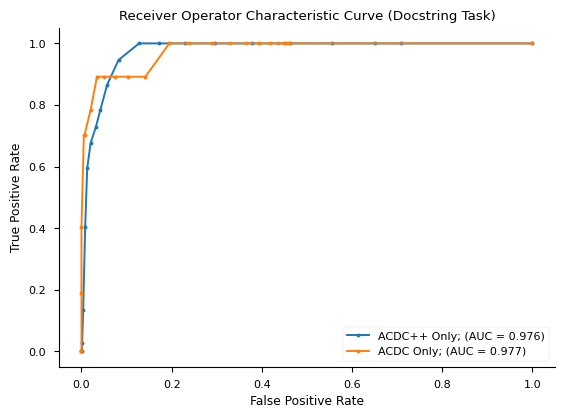

In [88]:
# Calculate AUC using trapezoidal rule
from sklearn.metrics import auc

from scipy import integrate

acdcpp_auc = round(abs(auc(df['ACDCpp FPR'], df['ACDCpp TPR'])), 3)
acdc_auc = round(
    abs(
        auc(
            orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_fpr'],
            orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_tpr']
        )
    ), 3)

plt.plot(df['ACDCpp FPR'], df['ACDCpp TPR'], marker='.', label=f'ACDC++ Only; (AUC = {acdcpp_auc})')
plt.plot(
    orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_fpr'],
    orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_tpr'],
    marker='.', 
    label=f'ACDC Only; (AUC = {acdc_auc})'
)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic Curve (Docstring Task)')
plt.legend()
plt.savefig('ROC_Curve.png')

In [92]:
orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC'].keys()

dict_keys(['steps', 'test_docstring_metric', 'score', 'test_kl_div', 'test_docstring_stefan', 'test_nll', 'test_match_nll', 'edge_fpr', 'edge_tpr', 'edge_precision', 'n_edges', 'node_fpr', 'node_tpr', 'node_precision', 'n_nodes'])

In [94]:
orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['test_nll']

[inf,
 6.28870964050293,
 5.1365556716918945,
 4.315356731414795,
 4.0975165367126465,
 2.9506542682647705,
 2.324460983276367,
 2.0739328861236572,
 1.8339952230453491,
 1.390416145324707,
 1.1645818948745728,
 1.0276647806167603,
 1.0224393606185913,
 1.0109184980392456,
 0.9042666554450989,
 1.0111387968063354,
 0.9957236647605896,
 1.0012856721878052,
 1.0057801008224487,
 1.0577392578125,
 1.0266523361206055,
 1.020729660987854,
 -inf]

In [91]:
df['pp_Youdens_J'] = df['ACDCpp TPR'] - df['ACDCpp FPR']
df['Youdens_J'] = df['TPR'] - df['FPR']
best_threshold_pp = df.loc[df['pp_Youdens_J'].idxmax(), 'Threshold']
best_threshold = df.loc[df['Youdens_J'].idxmax(), 'Threshold']
print(best_threshold_pp, best_threshold)

0.0473844 0.1688318
